# Getting Started

# Load libraries and extensions

In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import os, sys

from CNN import CNN, train, test, plot_confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
# import timeit
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Get device for training -- most of our work will be in CPU bc not using cluster
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


# Load/download data
The original PyTorch data comes in 28x28 pixels, but we will be working with some different sizes. 
- Pick the image shape you want to work with for this example. 
- The resizing of the images is done through the Pillow library via a Bilinear interpolation technique. 
  Bilinear interpolation considers the closest 2 × 2 neighborhood of known pixel values surrounding the unknown pixel's computed location. It then takes a weighted average of these 4 pixels to arrive at its final, interpolated value. (Wikipedia)
- Images are normalized to have values between [0,1]

The training and testing data will be store as PyTorch datasets. 

In [4]:
# select img size 
img_shape = 7
# store transformations: arrays to tensor, resize, and normalize
transform = [transforms.ToTensor(),
            transforms.Resize(img_shape),
            transforms.Normalize(0, 1)
            ]
# download training and testing data
train_data = datasets.MNIST(
    root = '../data/MNIST',
    train = True,                         
    transform = transforms.Compose(transform), 
    download = True,            
)
test_data = datasets.MNIST(
    root = '../data/MNIST', 
    train = False, 
    transform = transforms.Compose(transform),
    download = False,
)

In [20]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}

## Structure of the data
Take `train_data` as an example:
- `train_data` will give you general information about the training dataset (e.g. number of samples, location of data, transforms, etc)
- `train_data[i]` for $i \in [0, 60000-1]$ will give you a (image, label) pair
- To access the image: `train_data[i][0]`
- To access the image: `train_data[i][1]`

In [5]:
# get metadata of training data
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/MNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=7, interpolation=PIL.Image.BILINEAR)
               Normalize(mean=0, std=1)
           )

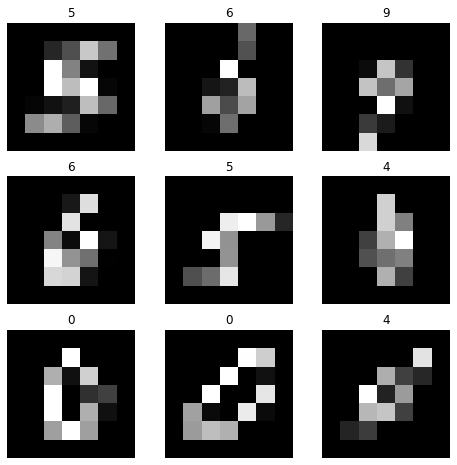

In [15]:
# visualize some digit images
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
#

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        '''
        Goes through two layers of 2D convolutions, each followed by a 2x2 max pooling
        
        Dimensions:
        1.) Input Shape:          [batch_size, 1, 7, 7]
        
        2.) After conv:           [batch_size, 4, 6, 6]
            After max pooling:    [batch_size, 4, 3, 3]
        
        3.) After conv:           [batch_size, 8, 2, 2]
            After max pooling:    [batch_size, 8, 1, 1]
            
        4.) After flattening:     [batch_size, 8 * 1 * 1]
        '''
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=4,            
                kernel_size=2,              
                stride=1,                   
                padding=0,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(4, 8, 2, 1, 0),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(8 * 1 * 1, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 16 * 8 * 8)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 8 output channels, 2x2 square convolution kernel
        self.conv1 = nn.Conv2d(1, 8, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 2)
        self.pool = nn.MaxPool2d(2, 2)
        #self.conv3 = nn.Conv2d(16, 32, 2)
        self.fc1 = nn.Linear(16 * 1 * 1, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = (F.relu(self.conv3(x)))
        x = x.view(-1, 16 * 1* 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x
net = Net()

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3) 

# Training

In [36]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loaders['train'], 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.115
[1,   200] loss: 0.115
[1,   300] loss: 0.115
[1,   400] loss: 0.115
[1,   500] loss: 0.115
[1,   600] loss: 0.115
[2,   100] loss: 0.115
[2,   200] loss: 0.115
[2,   300] loss: 0.115
[2,   400] loss: 0.115
[2,   500] loss: 0.115
[2,   600] loss: 0.115
Finished Training


# Save the model

In [41]:
PATH = '../models/mnist_net.pth'
torch.save(net.state_dict(), PATH)

## Load network from saved path

In [42]:
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [44]:
dataiter = iter(loaders['test'])
images, labels = dataiter.next()

In [45]:
outputs = net(images)

In [49]:
_, predicted = torch.max(outputs, 1)

In [52]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in loaders['test']:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 9 %


In [66]:
classes = [i for i in range(10)]
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in loaders['test']:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[label] += 1
            total_pred[label] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

KeyError: tensor(6)

In [61]:
total_pred[4]

0

In [3]:
sizes = [28, 14, 7, 4]
train_data = [None, None, None, None]
loss_data = [None, None, None, None]
test_data = [None, None, None, None]
cmt = [None, None, None, None]
cnn = [None, None, None, None]
model_acc = [None, None, None, None]

for i in range(len(cnn)):
    cnn[i] = CNN(img_shape = sizes[i], noise = False)
    

/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1631631159818/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
for i in range(len(cnn)):
    start = timeit.default_timer()
    print("Training", sizes[i], 'x', sizes[i], "...")
    train_data[i], loss_data[i] = train(cnn[i], cnn[i].loaders, 100)
    end = timeit.default_timer()
    time = np.round((end - start) / 60, 2)
    print('Training completed in ', time, 'minutes\n')
    
    print("Testing...")
    start = timeit.default_timer()
    cmt[i], test_data[i] = test(cnn[i], cnn[i].loaders)
    end = timeit.default_timer()
    time = np.round((end - start) / 60, 2)
    print('Testing completed in ', time, 'minutes\n')
    
    print('Saving the models...')
    
    model_path = '../models/March_28th_2022/' + str(sizes[i]) + 'x' + str(sizes[i]) + '/cnn_model'
    weights_path = '../models/March_28th_2022/' + str(sizes[i]) + 'x' + str(sizes[i]) + '/cnn_weights'
    loss_path = '../models/March_28th_2022/' + str(sizes[i]) + 'x' + str(sizes[i]) + '/loss_data'
    train_acc_path = '../models/March_28th_2022/' + str(sizes[i]) + 'x' + str(sizes[i]) + '/train_acc_data'
    test_acc_path = '../models/March_28th_2022/' + str(sizes[i]) + 'x' + str(sizes[i]) + '/test_acc_data'
    cmt_path = '../models/March_28th_2022/' + str(sizes[i]) + 'x' + str(sizes[i]) + '/confusion_matrix'
        
    torch.save(cnn[i], model_path)
    torch.save(cnn[i].state_dict(), weights_path)
    print("Done Saving\n")

Training 28 x 28 ...
Training...
Done training
Training completed in  49.33 minutes

Testing...
Testing...
Testing completed in  0.05 minutes

Saving the models...
Done Saving

Training 14 x 14 ...
Training...
Done training
Training completed in  28.95 minutes

Testing...
Testing...
Testing completed in  0.05 minutes

Saving the models...
Done Saving

Training 7 x 7 ...
Training...
Done training
Training completed in  27.03 minutes

Testing...
Testing...
Testing completed in  0.04 minutes

Saving the models...
Done Saving

Training 4 x 4 ...
Training...
Done training
Training completed in  27.62 minutes

Testing...
Testing...
Testing completed in  0.04 minutes

Saving the models...
Done Saving



In [31]:
total = 0
correct = 0

for i in range(len(cnn)):
    for x in range(10):
        for y in range(10):
            total += cmt[i][x][y]
            if x == y:
                correct += cmt[i][x][y]
    accuracy = correct / total
    print("Accuracy ", sizes[i], 'x', sizes[i], ': ', accuracy )
    correct = 0
    total = 0




Accuracy  28 x 28 :  tensor(0.8796)
Accuracy  14 x 14 :  tensor(0.5582)
Accuracy  7 x 7 :  tensor(0.2534)
Accuracy  4 x 4 :  tensor(0.1830)


In [34]:
test_data[1][99]

0.6

In [21]:
correct

tensor(18742)

Confusion matrix, without normalization


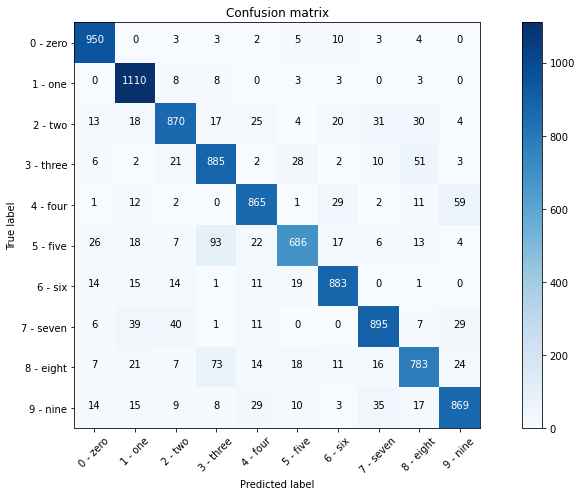

<Figure size 864x504 with 0 Axes>

Confusion matrix, without normalization


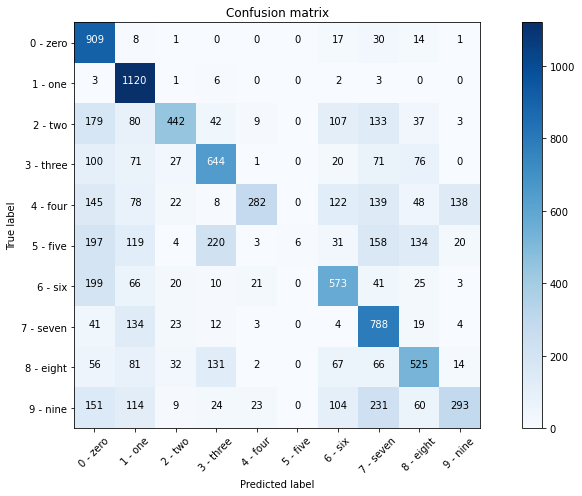

<Figure size 864x504 with 0 Axes>

Confusion matrix, without normalization


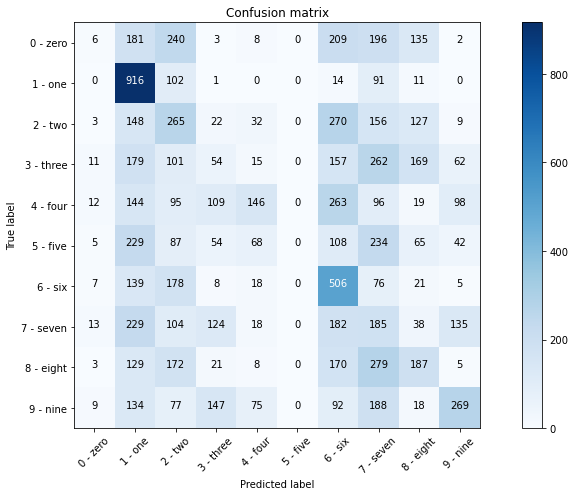

<Figure size 864x504 with 0 Axes>

Confusion matrix, without normalization


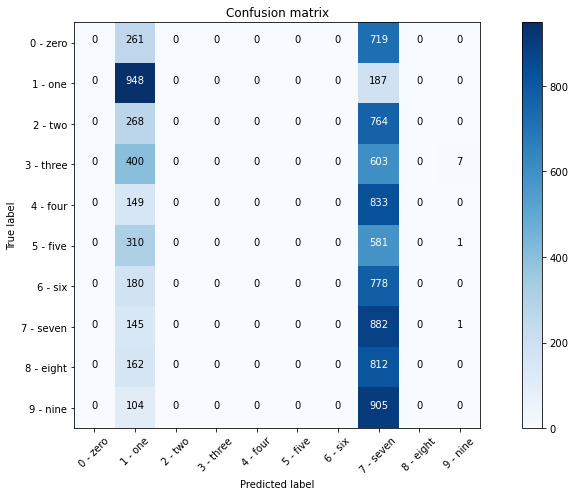

<Figure size 864x504 with 0 Axes>

In [29]:
for i in range(len(cnn)):
    plt.figure(figsize=(12,7))
    plot_confusion_matrix(cmt[i],  cnn[i].test_data.classes)

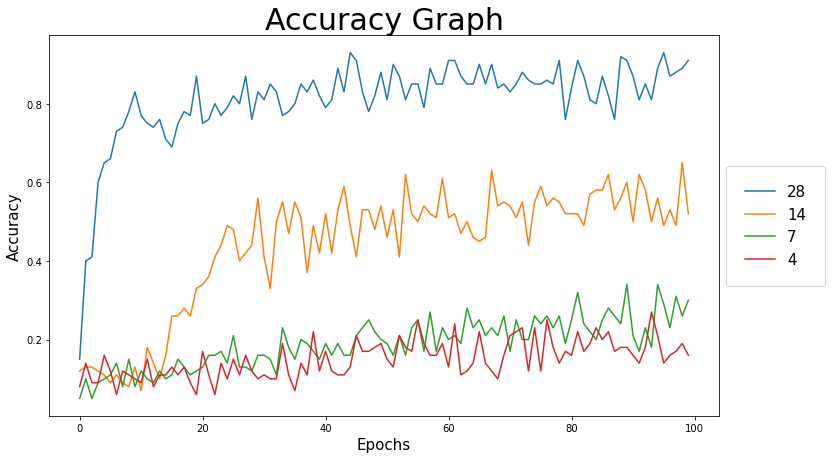

In [60]:
plt.figure(figsize=(12,7))
plt.title('Accuracy Graph', fontsize=30)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
for i in range(len(train_data)):
    plt.plot(train_data[i], label = sizes[i])
    plt.legend()

# Move labels outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderpad=1.25, prop={"size":15})

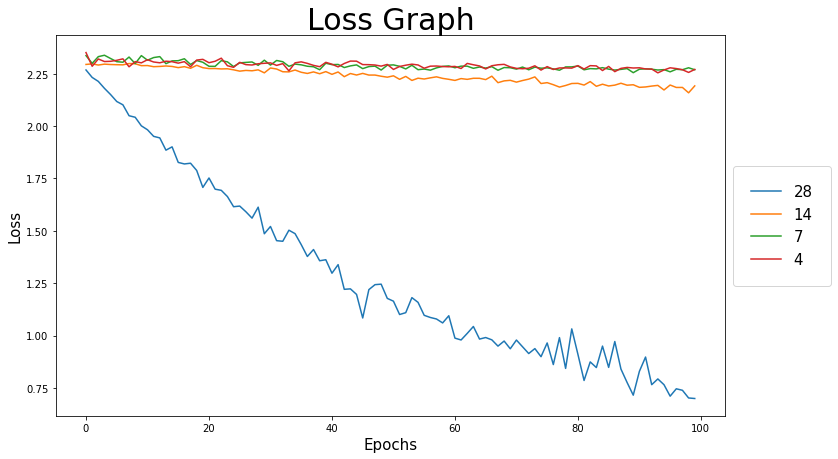

In [59]:
plt.figure(figsize=(12,7))
plt.title('Loss Graph', fontsize=30)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
for i in range(len(loss_data)):
    plt.plot(loss_data[i], label = sizes[i])
    plt.legend()

# Move labels outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderpad=1.25, prop={"size":15})

In [61]:
index = 3
model_name = str(sizes[index]) + 'x'+str(sizes[index])
sd = [0.005, 0.05, 0.1, 0.25, 0.5]
sd_index = 3
path = '/Users/cristianespinosa/Documents/UCM_Undergraduate_Research/models/April_5th_2022/noisy_data_training/' + model_name + '/sd_' + str(sd[sd_index]) + '/cnn_model' 
size = (1,1,sizes[index],sizes[index])
dummy = torch.load(path)

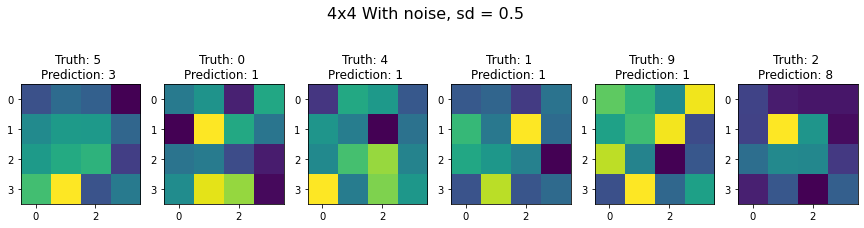

In [62]:
fig, axs = plt.subplots(1,6, figsize=(15,4))
axs = axs.ravel()
for i in range(6):
    resized = np.resize(dummy.train_data[i][0][0], size)
    test_output, last_layer = dummy(torch.tensor(resized))
    pred_y = torch.max(test_output, 1)[1].numpy()[0]
    
    axs[i].imshow(dummy.train_data[i][0][0])
    axs[i].set_title('Truth: %i \nPrediction: %s '%(dummy.train_data[i][1],pred_y ))

fig.suptitle(model_name+ ' With noise, sd = ' + str(sd[sd_index]), fontsize=16)
#plt.subplots_adjust(top=0.1)
plt.show()
#fig.savefig('7x7_no_noise.png')


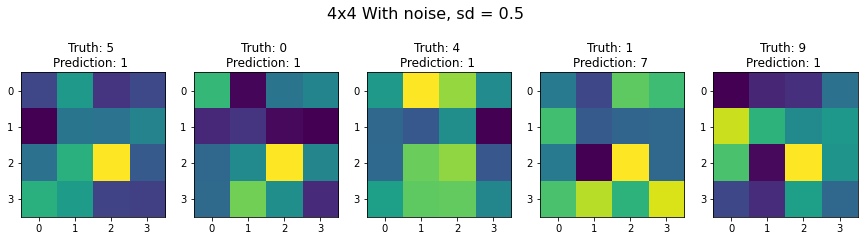

In [68]:
fig, axs = plt.subplots(1,5, figsize=(15,4))
axs = axs.ravel()
for i in range(5):
    resized = np.resize(dummy.train_data[i][0][0], size)
    test_output, last_layer = dummy(torch.tensor(resized))
    pred_y = torch.max(test_output, 1)[1].numpy()[0]
    
    axs[i].imshow(dummy.train_data[0][0][0])
    axs[i].set_title('Truth: %i \nPrediction: %s '%(dummy.train_data[i][1],pred_y ))

fig.suptitle(model_name+ ' With noise, sd = ' + str(sd[sd_index]), fontsize=16)
#plt.subplots_adjust(top=0.1)
plt.show()
#fig.savefig('7x7_no_noise.png')


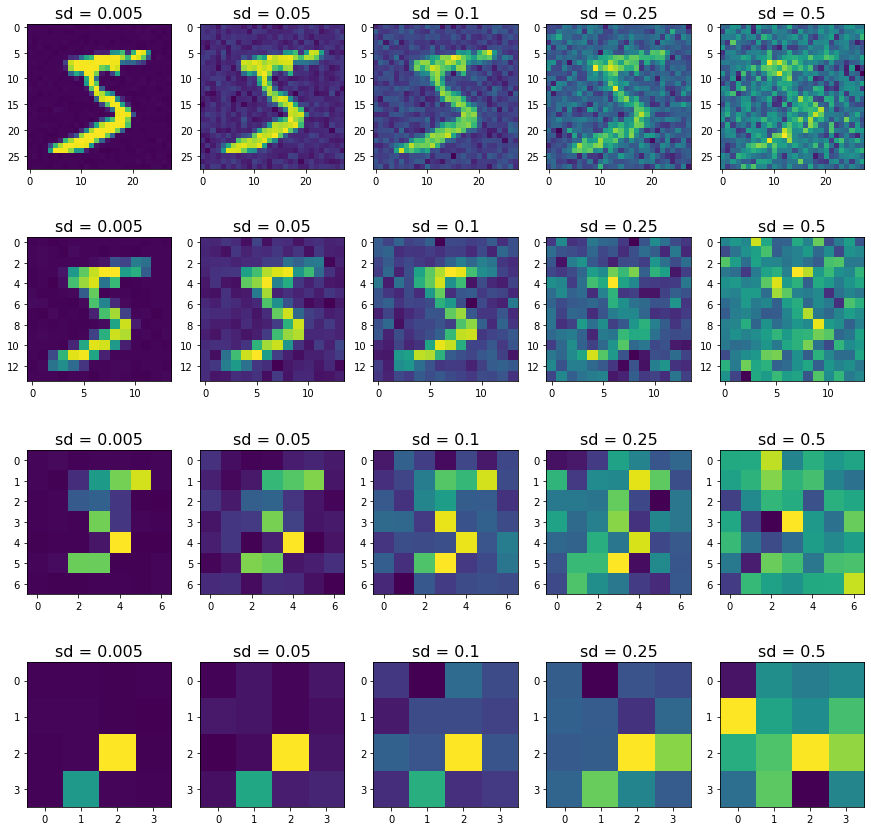

In [88]:
fig, axs = plt.subplots(4,5, figsize=(15,15))
# axs = axs.ravel()

for i in range(4):
    for j in range(5):
        
        axs[i][j].set_title('sd = '+str(sd[j]), fontsize=16)
        dummy = CNN(img_shape=sizes[i], noise=True, sd = sd[j])
        axs[i][j].imshow(dummy.train_data[0][0][0])

Confusion matrix, without normalization


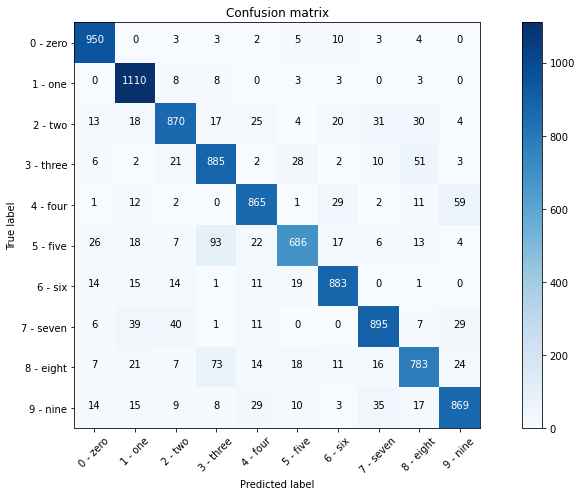

<Figure size 864x504 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [63]:
plt.figure(figsize=(12,7))
plot_confusion_matrix(cmt[0], dummy.test_data.classes)
plt.savefig('../models/April_5th_2022/confusion_matrix_28x28_with_noise.png')

Confusion matrix, without normalization


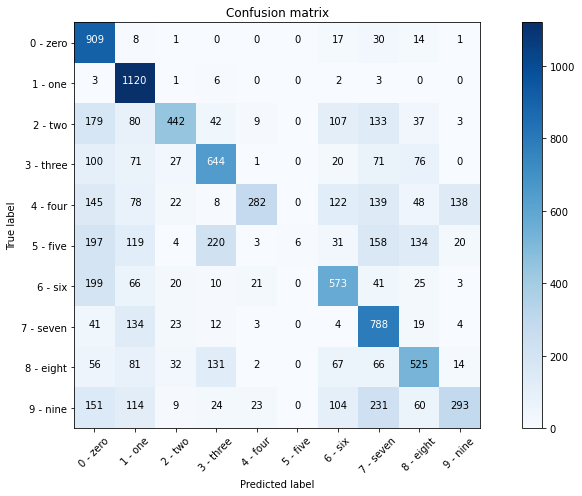

<Figure size 864x504 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [64]:
plt.figure(figsize=(12,7))
plot_confusion_matrix(cmt[1], dummy.test_data.classes)
plt.savefig('../models/April_5th_2022/confusion_matrix_14x14_with_noise.png')

Confusion matrix, without normalization


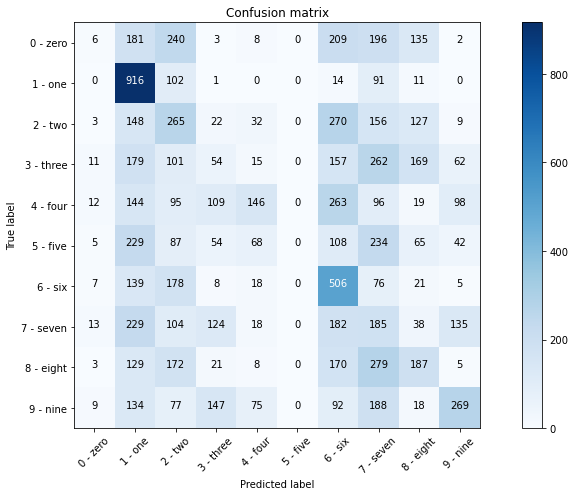

<Figure size 864x504 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [65]:
plt.figure(figsize=(12,7))
plot_confusion_matrix(cmt[2], dummy.test_data.classes)
plt.savefig('../models/April_5th_2022/confusion_matrix_7x7_without_noise.png')

In [ ]:
plt.figure(figsize=(12,7))
plot_confusion_matrix(cmt[3], dummy.test_data.classes)
plt.savefig('../models/April_5th_2022/confusion_matrix_4x4_without_noise.png')

In [ ]:
# for i in range(len(cnn)):
#     model_path = '../models/March_28th_2022/cnn_model' + str(sizes[i]) + 'x' + str(sizes[i])
#     cnn[i] = torch.load(model_path)
#     loss_data = np.load('../models/March_28th_2022/cnn_loss_data.npy', allow_pickle=True)
#     test_data = np.load('../models/March_28th_2022/cnn_test_acc_data.npy')
#     train_data = np.load('../models/March_28th_2022/cnn_train_acc_data.npy', allow_pickle=True)

In [ ]:
# dummy = CNN(noise=True)
# train(dummy, loaders = dummy.loaders, num_epochs=2)

In [ ]:
# cmt = test(dummy, dummy.loaders)

In [ ]:
# plt.figure(figsize=(10,10))
# plot_confusion_matrix(cmt, dummy.test_data.classes)

In [ ]:
# plt.imshow(dummy.train_data[2][0][0])
# print(dummy.train_data[2][1])

In [ ]:
# plt.imshow(cnn[0].train_data[2][0][0])

In [ ]:
# plt.figure(figsize = (12,7))
# sn.heatmap(test_data[0], annot=True, cmap='Blues')
# plt.savefig('../models/confusion_matrix_28x28.png')

In [ ]:
plt.figure(figsize = (12,7))
sn.heatmap(test_data[1], annot=True, cmap='Blues')
# plt.savefig('../models/confusion_matrix_14x14.png')

In [ ]:
# plt.figure(figsize = (12,7))
# sn.heatmap(test_data[2], annot=True, cmap='Blues')
# plt.savefig('../models/confusion_matrix_7x7.png')

In [ ]:
# plt.figure(figsize = (12,7))
# sn.heatmap(test_data[3], annot=True, cmap='Blues')
# plt.savefig('../models/confusion_matrix_4x4.png')

In [ ]:
# train_data = np.array(train_data)
# np.save('../models/cnn_train_acc_data', train_data)

# test_data = np.array(test_data)
# np.save('../models/cnn_test_acc_data', test_data)

# loss_data = np.array(loss_data)
# np.save('../models/cnn_loss_data', loss_data)

In [ ]:
# rows = 4
# cols = 2
# f, axarr = plt.subplots(rows, cols, figsize=(20, 25))
# for i in range(rows):
#     for j in range(cols):
#         if j == 0:
#             title = "Train Accuracy (" + str(sizes[i]) + "x" + str(sizes[i]) + ")"
#             axarr[i][j].set_title(title)
#             axarr[i][j].set_xlabel("Epochs")
#             axarr[i][j].set_ylabel("Accuracy")
#             axarr[i][j].plot(train_data[i])
#         else:
#             title = "Loss Data (" + str(sizes[i]) + "x" + str(sizes[i]) + ")"
#             axarr[i][j].set_title(title)
#             axarr[i][j].set_xlabel("Epochs")
#             axarr[i][j].set_ylabel("Loss")
#             axarr[i][j].plot(loss_data[i])


In [ ]:
# test_data = np.load('../models/March_28th_2022/cnn_test_acc_data.npy')
# train_data = np.load('../models/March_28th_2022/cnn_train_acc_data.npy', allow_pickle=True)

In [ ]:
train_data[3]